In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
from  sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml("mnist_784",version=1)

In [5]:
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [6]:
X,y = mnist['data'],mnist['target']

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

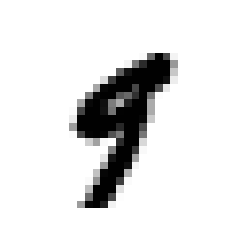

In [10]:
random_digit = X.loc[36000]
random_digit = random_digit.values.reshape(28,28)
plt.imshow(random_digit,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [11]:
y.loc[36000]

'9'

In [12]:
X_train,X_test,y_train,y_test = X.iloc[:60000],X.iloc[60000:],y.iloc[:60000],y.iloc[60000:]

In [13]:
shuffle_index = np.random.permutation(60000)
X_train = X_train.loc[shuffle_index]
y_train = y_train.loc[shuffle_index]

## Training a Binary Classifier

In [14]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [15]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(random_state=31)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=31)

In [23]:
sgd_clf.predict([X.iloc[36000]])

array([False])

### Implementing Cross-Validation

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [26]:
skflods = StratifiedKFold(n_splits=3,random_state=31,shuffle=True)

In [28]:
for train_index,test_index in skflods.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    x_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9426
0.96485
0.95995


In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.96675, 0.91565, 0.96055])

In [31]:
from sklearn.base import BaseEstimator

In [32]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9121 , 0.9102 , 0.90665])

## Confusion Matrix

In [34]:
from sklearn.model_selection import cross_val_predict

In [36]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [37]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_train_5,y_train_pred)

array([[52710,  1869],
       [ 1272,  4149]], dtype=int64)

In [40]:
import seaborn as sns

In [45]:
y_train_perfect_predictions = y_train_5

In [46]:
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [47]:
from sklearn.metrics import precision_score,recall_score

In [48]:
precision_score(y_train_5,y_train_pred)

0.689431704885344

In [49]:
4149/(4149+1869)

0.689431704885344

In [50]:
recall_score(y_train_5,y_train_pred)

0.7653569452130603

In [51]:
4149/(4149+1272)

0.7653569452130603

In [52]:
from sklearn.metrics import f1_score

In [53]:
f1_score(y_train_5,y_train_pred)

0.7254130605822188

In [56]:
y_score = sgd_clf.decision_function([X.loc[36000]])

In [57]:
y_score

array([-5537.10087615])

In [62]:
threshold = -6000

In [63]:
y_some_digit_pred = (y_score > threshold)

In [64]:
y_some_digit_pred

array([ True])

In [65]:
from sklearn.metrics import precision_recall_curve

In [68]:
y_scores = sgd_clf.decision_function(X_train)

In [69]:
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [70]:
def plot_precision_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0,1])

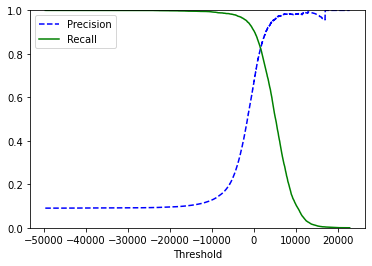

In [72]:
plot_precision_vs_threshold(precisions=precisions,recalls=recalls,thresholds=thresholds)
plt.show()